# 31009 - Assignment 2: Regression with Gradient Descent

Use linear regression with gradient descent to predict water temperature T_degC using the dataset from assignment 1.

1) Only use 'Salnty', 'STheta' for predictors (same as HW #1)

2) Remove NaN / NA values from dataset (prior to building train/test sets) (same as HW #1)

3) Scale all features to improve convergence. It is highly encouraged that you review the appropriate method of handling normalization with train & test. Additional info on scaling with train & test sets: https://stats.stackexchange.com/questions/174823/how-to-apply-standardization-normalization-to-train-and-testset-if-prediction-i

Feel free to use the sklearn tool "StandardScaler" - more info here: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html (Links to an external site.)Links to an external site. 

4) For the cost function we will use mean squared error. Please use the same function utilized in Chapter 4 of The Hands On Machine Learning (Equation 4.5) for the derivative of the cost function. 

Example code from chapter: 

derived_cost_function = 2/m * X_b.T.dot(X_b.dot(theta) - y)  

5) Try mini batch sizes of 50, 2000 and 10,000. Comment on the prediction accuracy based on rmse, variance explained, and r-squared.

Note: Feel free to use any value for eta and epochs, but 0.1 eta and 100 epochs are fine for this HW. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import statsmodels.api as sm
import time

%matplotlib inline

/Users/rowena/miniconda3/envs/msca/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv('data/bottle.csv')
df = df.loc[:,['Salnty', 'STheta', 'T_degC']]

/Users/rowena/miniconda3/envs/msca/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (47,73) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print('There are {0} rows in raw dataset\n'.format(len(df)))

print("Remove {0} rows because of missing values in Salnty".format(sum(df.Salnty.isna())))
df = df[~df.Salnty.isna()]

print("Remove {0} rows because of missing values in STheta".format(sum(df.STheta.isna())))
df = df[~df.STheta.isna()]

print("Remove {0} rows because of missing values in T_degC\n".format(sum(df.T_degC.isna())))
df = df[~df.T_degC.isna()]

print("Clean dataset has {0} rows".format(len(df)))

There are 864863 rows in raw dataset

Remove 47354 rows because of missing values in Salnty
Remove 5335 rows because of missing values in STheta
Remove 0 rows because of missing values in T_degC

Clean dataset has 812174 rows


## Remove Outliers

There are big outliers in STheta that need to be removed or else they will screw up the line of best fit.

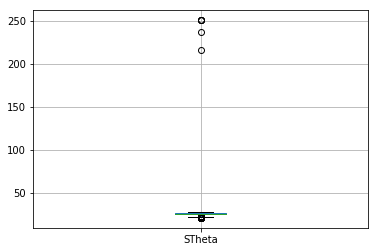

In [4]:
df.boxplot(column='STheta')

In [5]:
df = df[df.STheta <= 50]

## Split into Test / Train

In this assignment I am using a 70/30 test/train split

In [6]:
np.random.seed(123)
msk = np.random.rand(len(df)) < 0.7
tn = df[msk]
tt = df[~msk]

## Normalize the Data

Scale each variable in train and test. The test data should be scaled with training mean and sd to avoid information leakage.  
It is not necessary to scale the response variable.

In [7]:
means = tn.mean()
stdvs = tn.std()

In [8]:
tn.loc[:,'Salnty'] = (tn.Salnty - means['Salnty']) / stdvs['Salnty']
tn.loc[:,'STheta'] = (tn.STheta - means['STheta']) / stdvs['STheta']

tt.loc[:,'Salnty'] = (tt.Salnty - means['Salnty']) / stdvs['Salnty']
tt.loc[:,'STheta'] = (tt.STheta - means['STheta']) / stdvs['STheta']

/Users/rowena/miniconda3/envs/msca/lib/python3.6/site-packages/pandas/core/indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


## Gradient Descent

Gradient descent calculates a partial derivitaive at each step at then goes the other way to attempt to find a global mininum in the cost function. If done correctly it should reach the same answer as solving for the cost function directly but without the computational expense of inverting a matrix.

In [9]:
X_b = tn[tn.columns[0:2]]
X_b.insert(0, 'intercept', 1)
y = tn.T_degC

In [10]:
X_b.head()

,intercept,Salnty,STheta
0,1,-0.871123,-0.167803
1,1,-0.871123,-0.160851
2,1,-0.877622,-0.162837
3,1,-0.914454,-0.173761
5,1,-0.890622,-0.165817


In [11]:
def mini_batch_gradient_descent(X_b, y, n_epochs, minibatch_size, eta):
    m = len(X_b)

    np.random.seed(123)
    theta = np.random.randn(3,1) 
    
    for epoch in range(n_epochs):
        shuffled_indices = np.random.choice(X_b.index, m, replace=False)
        X_b_shuffled = X_b.loc[shuffled_indices]
        y_shuffled = y.loc[shuffled_indices]
        y_shuffled = np.asarray(y_shuffled).reshape((len(y_shuffled),1))
        for i in range(0, m, minibatch_size):
            xi = X_b_shuffled[i:i+minibatch_size]
            yi = y_shuffled[i:i+minibatch_size]
            derived_cost_function = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
            theta = theta - eta * derived_cost_function
    return(theta)

Compute estimates of the linear regression using the the mini-batch gradient descent on different batch sizes: 50, 2,000, and 50,000. For each batch size we'll use 20 iterations and a 0.1 learning step.

In [19]:
start = time.time()
theta_50 = mini_batch_gradient_descent(X_b, y, 20, 50, 0.1)
end = time.time()
time_50 = end - start
print("Mini-batch Gradient Descent with a 50 minibatch size")
print(theta_50)
print("MBGD 50 took about {} seconds.".format(round(time_50)))

start = time.time()
theta_2000 = mini_batch_gradient_descent(X_b, y, 20, 2000, 0.1)
end = time.time()
time_2000 = end - start
print("\nMini-batch Gradient Descent with a 2,000 minibatch size")
print(theta_2000)
print("MBGD 2,000 took about {} seconds.".format(round(time_2000)))

start = time.time()
theta_50000 = mini_batch_gradient_descent(X_b, y, 20, 50000, 0.1)
end = time.time()
time_50000 = end - start
print("\nMini-batch Gradient Descent with a 50,000 minibatch size")
print(theta_50000)
print("MBGD 50,000 took about {} seconds.".format(round(time_50000)))

Mini-batch Gradient Descent with a 50 minibatch size
                   0
intercept  10.853977
Salnty      1.414366
STheta     -5.053720
MBGD 50 took about 469 seconds.

Mini-batch Gradient Descent with a 2,000 minibatch size
                   0
intercept  10.846961
Salnty      1.446968
STheta     -5.074566
MBGD 2,000 took about 17 seconds.

Mini-batch Gradient Descent with a 50,000 minibatch size
                   0
intercept  10.845809
Salnty      1.435034
STheta     -5.073946
MBGD 50,000 took about 7 seconds.


In [20]:
tn_pred_50 = theta_50[0][0] + theta_50[0][1] * tn.Salnty + theta_50[0][2] * tn.STheta
tt_pred_50 = theta_50[0][0] + theta_50[0][1] * tt.Salnty + theta_50[0][2] * tt.STheta

tn_rmse_50 = (((tn_pred_50 - tn.T_degC)**2).sum() / len(tn))**0.5
tt_rmse_50 = (((tt_pred_50 - tt.T_degC)**2).sum() / len(tt))**0.5

print("Train RSME: {}".format(round(tn_rmse_50, 4)))
print("Test  RSME: {}".format(round(tt_rmse_50, 4)))

tn_var = ((tn.T_degC - tn.T_degC.mean())**2).mean()
tt_var = ((tt.T_degC - tt.T_degC.mean())**2).mean()

print("Train Variance: {}".format(round(tn_var, 2)))
print("Test  Variance: {}".format(round(tt_var, 2)))

tn_var_explained_50 = tn_var - tn_rmse_50**2
tt_var_explained_50 = tt_var - tt_rmse_50**2

print("Train Variance Explained: {}".format(round(tn_var_explained_50, 2)))
print("Test  Variance Explained: {}".format(round(tt_var_explained_50, 2)))

tn_r2_50 = tn_var_explained_50 / tn_var
tt_r2_50 = tt_var_explained_50 / tt_var

print("Train R2: {}".format(round(tn_r2_50, 6)))
print("Test  R2: {}".format(round(tt_r2_50, 6)))

Train RSME: 0.4828
Test  RSME: 0.484
Train Variance: 17.79
Test  Variance: 17.87
Train Variance Explained: 17.56
Test  Variance Explained: 17.63
Train R2: 0.986901
Test  R2: 0.986888


In [21]:
tn_pred_2000 = theta_2000[0][0] + theta_2000[0][1] * tn.Salnty + theta_2000[0][2] * tn.STheta
tt_pred_2000 = theta_2000[0][0] + theta_2000[0][1] * tt.Salnty + theta_2000[0][2] * tt.STheta

tn_rmse_2000 = (((tn_pred_2000 - tn.T_degC)**2).sum() / len(tn))**0.5
tt_rmse_2000 = (((tt_pred_2000 - tt.T_degC)**2).sum() / len(tt))**0.5

print("Train RSME: {}".format(round(tn_rmse_2000, 4)))
print("Test  RSME: {}".format(round(tt_rmse_2000, 4)))

tn_var = ((tn.T_degC - tn.T_degC.mean())**2).mean()
tt_var = ((tt.T_degC - tt.T_degC.mean())**2).mean()

print("Train Variance: {}".format(round(tn_var, 2)))
print("Test  Variance: {}".format(round(tt_var, 2)))

tn_var_explained_2000 = tn_var - tn_rmse_2000**2
tt_var_explained_2000 = tt_var - tt_rmse_2000**2

print("Train Variance Explained: {}".format(round(tn_var_explained_2000, 2)))
print("Test  Variance Explained: {}".format(round(tt_var_explained_2000, 2)))

tn_r2_2000 = tn_var_explained_2000 / tn_var
tt_r2_2000 = tt_var_explained_2000 / tt_var

print("Train R2: {}".format(round(tn_r2_2000, 6)))
print("Test  R2: {}".format(round(tt_r2_2000, 6)))

Train RSME: 0.4826
Test  RSME: 0.4839
Train Variance: 17.79
Test  Variance: 17.87
Train Variance Explained: 17.56
Test  Variance Explained: 17.63
Train R2: 0.986911
Test  R2: 0.986896


In [22]:
tn_pred_50000 = theta_50000[0][0] + theta_50000[0][1] * tn.Salnty + theta_50000[0][2] * tn.STheta
tt_pred_50000 = theta_50000[0][0] + theta_50000[0][1] * tt.Salnty + theta_50000[0][2] * tt.STheta

tn_rmse_50000 = (((tn_pred_50000 - tn.T_degC)**2).sum() / len(tn))**0.5
tt_rmse_50000 = (((tt_pred_50000 - tt.T_degC)**2).sum() / len(tt))**0.5

print("Train RSME: {}".format(round(tn_rmse_50000, 4)))
print("Test  RSME: {}".format(round(tt_rmse_50000, 4)))

tn_var = ((tn.T_degC - tn.T_degC.mean())**2).mean()
tt_var = ((tt.T_degC - tt.T_degC.mean())**2).mean()

print("Train Variance: {}".format(round(tn_var, 2)))
print("Test  Variance: {}".format(round(tt_var, 2)))

tn_var_explained_50000 = tn_var - tn_rmse_50000**2
tt_var_explained_50000 = tt_var - tt_rmse_50000**2

print("Train Variance Explained: {}".format(round(tn_var_explained_50000, 2)))
print("Test  Variance Explained: {}".format(round(tt_var_explained_50000, 2)))

tn_r2_50000 = tn_var_explained_50000 / tn_var
tt_r2_50000 = tt_var_explained_50000 / tt_var

print("Train R2: {}".format(round(tn_r2_50000, 6)))
print("Test  R2: {}".format(round(tt_r2_50000, 6)))

Train RSME: 0.4825
Test  RSME: 0.4838
Train Variance: 17.79
Test  Variance: 17.87
Train Variance Explained: 17.56
Test  Variance Explained: 17.63
Train R2: 0.986918
Test  R2: 0.986903


## Results

This algorithm leads to shockingly accurate results. An R^2 of 0.99 is so good it makes me suspicious. The advantage of scaling data and removing outliers as compared to homework one is obvious. The gradient decent algorithm honed in on the right answer no matter the batch size, but the time it took to output was wildly different. It seems like in this case large batch sizes are better. 

The normalized results make it a bit more difficult to interpret the coefficients. Instead of units of X they are now in units of standard deviations of X.